# 二、收集数据和预处理

In [186]:
import pandas as pd 

df_sales = pd.read_csv('data.csv')
df_sales.head()

订单号     产品码           消费日期           产品说明  数量     单价    用户码  城市
0  536374   21258  6/1/2020 9:09        五彩玫瑰五支装  32  10.95  15100  北京
1  536376   22114  6/1/2020 9:32       茉莉花白色25枝  48   3.45  15291  上海
2  536376   21733  6/1/2020 9:32  教师节向日葵3枝尤加利5枝  64   2.55  15291  上海
3  536378   22386  6/1/2020 9:37       百合粉色10花苞  10   1.95  14688  北京
4  536378  85099C  6/1/2020 9:37       橙黄香槟色康乃馨  10   1.95  14688  北京

## 2.2 数据可视化

消费日期
2020-06-30    398
2020-07-31    252
2020-08-31    271
2020-09-30    337
2020-10-31    272
Freq: M, Name: 订单号, dtype: int64


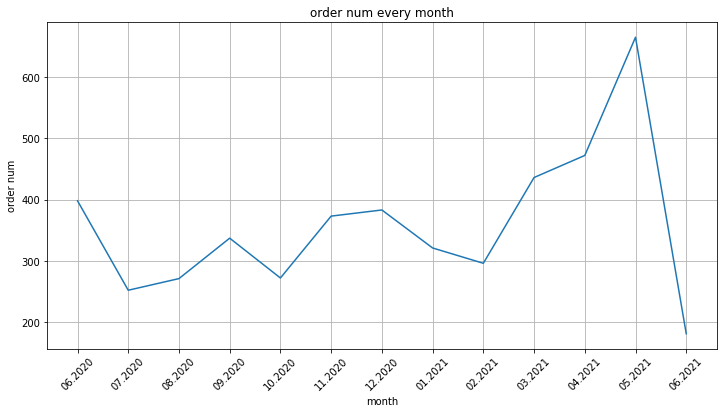

In [187]:
import matplotlib.pyplot as plt
df_sales['消费日期'] = pd.to_datetime(df_sales['消费日期'])
df_orders_monthly = df_sales.set_index('消费日期')['订单号'].resample('M').nunique() # 计算每个月的订单数量
print(df_orders_monthly.head())

ax = pd.DataFrame(df_orders_monthly.values).plot(grid=True,figsize=(12,6),legend=False)
ax.set_xlabel('month')
ax.set_ylabel('order num')
ax.set_title('order num every month')

plt.xticks(range(len(df_orders_monthly.index)),
            [x.strftime('%m.%Y') for x in df_orders_monthly.index],
            rotation=45)
plt.show()

## 2.3 数据清洗

In [188]:
df_sales = df_sales.drop_duplicates() # 删除重复行

df_sales.describe() # 通过统计信息查看是否有脏数据

数量            单价           用户码
count  85920.000000  85920.000000  85920.000000
mean      10.115747      3.599711  15338.080389
std       49.114285    134.410498    391.309086
min    -9360.000000      0.000000  14681.000000
25%        2.000000      1.250000  15022.000000
50%        4.000000      1.950000  15334.000000
75%       12.000000      3.750000  15673.000000
max     3114.000000  38970.000000  16019.000000

In [189]:
df_sales = df_sales.loc[df_sales['数量'] > 0]
df_sales.describe()

数量            单价           用户码
count  84112.000000  84112.000000  84112.000000
mean      10.760236      3.005032  15337.732963
std       34.018906     15.365085    392.074855
min        1.000000      0.000000  14681.000000
25%        2.000000      1.250000  15021.000000
50%        5.000000      1.950000  15333.000000
75%       12.000000      3.750000  15674.000000
max     3114.000000   3155.950000  16019.000000

## 2.4 特征工程

In [190]:
df_sales['总价'] = df_sales['数量'] * df_sales['单价']
df_sales.head()

订单号     产品码                消费日期           产品说明  数量     单价    用户码  城市  \
0  536374   21258 2020-06-01 09:09:00        五彩玫瑰五支装  32  10.95  15100  北京   
1  536376   22114 2020-06-01 09:32:00       茉莉花白色25枝  48   3.45  15291  上海   
2  536376   21733 2020-06-01 09:32:00  教师节向日葵3枝尤加利5枝  64   2.55  15291  上海   
3  536378   22386 2020-06-01 09:37:00       百合粉色10花苞  10   1.95  14688  北京   
4  536378  85099C 2020-06-01 09:37:00       橙黄香槟色康乃馨  10   1.95  14688  北京   

      总价  
0  350.4  
1  165.6  
2  163.2  
3   19.5  
4   19.5

In [191]:
df_user = pd.DataFrame(df_sales['用户码'].unique())
df_user.columns = ['用户码']
df_user = df_user.sort_values(by='用户码',ascending=True).reset_index(drop=True)
df_user.head()

用户码
0  14681
1  14682
2  14684
3  14687
4  14688

求R值

In [192]:
df_sales['消费日期'] = pd.to_datetime(df_sales['消费日期'])
df_recent_buy = df_sales.groupby('用户码').消费日期.max().reset_index()
df_recent_buy.columns = ['用户码', '最近日期']
# 用数据源中的最大消费日期 - 每个用户的最近消费日期
df_recent_buy['R值'] = (df_recent_buy['最近日期'].max() - df_recent_buy['最近日期']).dt.days
df_user = pd.merge(df_user, df_recent_buy[['用户码','R值']], on='用户码')
df_user.head()

用户码   R值
0  14681   70
1  14682  187
2  14684   25
3  14687  106
4  14688    7

求F值

In [193]:
df_frequency = df_sales.groupby('用户码').消费日期.count().reset_index()
df_frequency.columns = ['用户码', 'F值']
df_user = pd.merge(df_user, df_frequency, on='用户码')
df_user.head()

用户码   R值   F值
0  14681   70    7
1  14682  187    2
2  14684   25  390
3  14687  106   15
4  14688    7  324

求M值

In [194]:
df_revenue = df_sales.groupby('用户码').总价.sum().reset_index()
df_revenue.columns = ['用户码', 'M值']
df_user = pd.merge(df_user, df_revenue, on='用户码')
df_user.head()

用户码   R值   F值       M值
0  14681   70    7   498.95
1  14682  187    2    52.00
2  14684   25  390  1201.51
3  14687  106   15   628.38
4  14688    7  324  5579.10

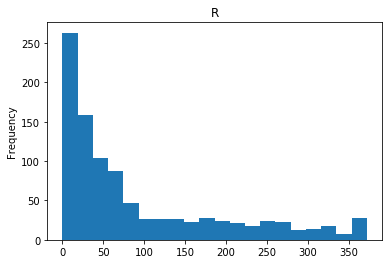

In [195]:
df_user['R值'].plot(kind='hist', bins=20, title='R') # bins 柱子数量

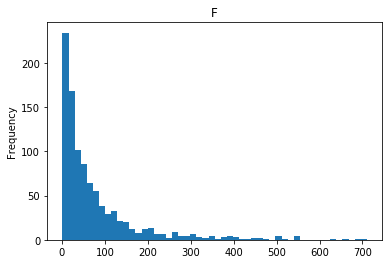

In [196]:
df_user.query('F值 < 800')['F值'].plot(kind='hist', bins=50, title='F')

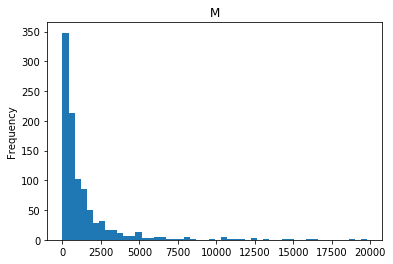

In [197]:
df_user.query('M值 < 20000')['M值'].plot(kind='hist', bins=50, title='M')

# 三、选择算法并建立模型

手肘法确定K值

In [198]:
from sklearn.cluster import KMeans

def show_elbow(df):     # 定义手肘函数
    distance_list = [] # 距质心的距离
    K = range(1, 9) # K值范围
    for k in K:
        kmeans = KMeans(n_clusters=k, max_iter=100) # 创建 KMeans 模型，最大迭代100次
        kmeans = kmeans.fit(df) # 拟合模型
        distance_list.append(kmeans.inertia_) # 每个K值的损失
    plt.plot(K, distance_list, 'bx-')
    plt.xlabel('k')
    plt.ylabel('距离均方误差')
    plt.title('k_elbow')

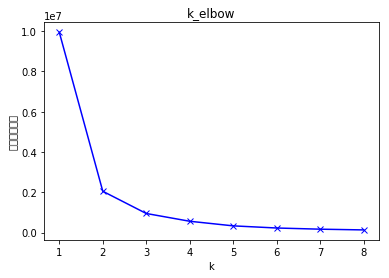

In [199]:
show_elbow(df_user[['R值']])

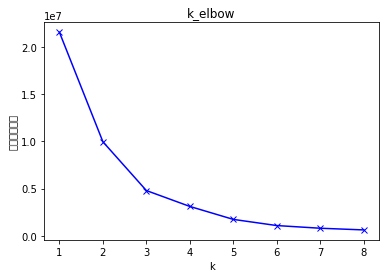

In [200]:
show_elbow(df_user[['F值']])

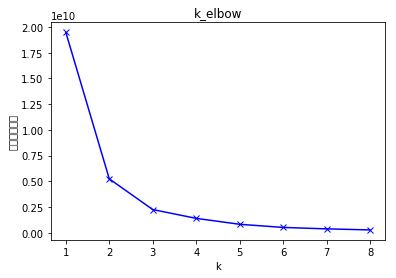

In [201]:
show_elbow(df_user[['M值']])

创建和训练模型

In [202]:
from sklearn.cluster import KMeans

kmeans_R = KMeans(n_clusters=3)
kmeans_F = KMeans(n_clusters=4)
kmeans_M = KMeans(n_clusters=4)

kmeans_R.fit(df_user[['R值']])
kmeans_F.fit(df_user[['F值']])
kmeans_M.fit(df_user[['M值']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

使用模型进行聚类

In [203]:
df_user['R值层级'] = kmeans_R.predict(df_user[['R值']]) # 不需要进行模型的评估和优化
df_user.head()

用户码   R值   F值       M值  R值层级
0  14681   70    7   498.95     0
1  14682  187    2    52.00     2
2  14684   25  390  1201.51     0
3  14687  106   15   628.38     2
4  14688    7  324  5579.10     0

In [204]:
df_user.groupby('R值层级')['R值'].describe()

count        mean        std    min     25%    50%     75%    max
R值层级                                                                   
0     664.0   32.088855  25.141763    0.0   10.00   25.0   50.00   94.0
1     138.0  298.094203  45.436550  231.0  255.25  292.5  334.50  372.0
2     178.0  157.162921  37.340870   95.0  126.00  156.5  188.75  225.0

聚类后概念化

In [205]:
def order_cluster(cluster_name, target_name, df, ascending=False):
    df_new = df.groupby(cluster_name)[target_name].mean().reset_index() #按聚类结果分组，创建df_new对象
    df_new = df_new.sort_values(by=target_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_new = pd.merge(df, df_new[[cluster_name, 'index']],on=cluster_name)
    df_new = df_new.drop([cluster_name], axis=1)
    df_new = df_new.rename(columns={'index':cluster_name})
    return df_new

In [206]:
df_user = order_cluster('R值层级', 'R值', df_user, False)
df_user = df_user.sort_values(by='用户码',ascending=True).reset_index(drop=True)
df_user.head()

用户码   R值   F值       M值  R值层级
0  14681   70    7   498.95     2
1  14682  187    2    52.00     1
2  14684   25  390  1201.51     2
3  14687  106   15   628.38     1
4  14688    7  324  5579.10     2

In [207]:
df_user.groupby('R值层级')['R值'].describe()

count        mean        std    min     25%    50%     75%    max
R值层级                                                                   
0     138.0  298.094203  45.436550  231.0  255.25  292.5  334.50  372.0
1     178.0  157.162921  37.340870   95.0  126.00  156.5  188.75  225.0
2     664.0   32.088855  25.141763    0.0   10.00   25.0   50.00   94.0

In [208]:
df_user['F值层级'] = kmeans_F.predict(df_user[['F值']])
df_user = order_cluster('F值层级', 'F值', df_user, True)
df_user.groupby('F值层级')['F值'].describe()

count         mean         std    min     25%     50%      75%     max
F值层级                                                                        
0     720.0    32.277778   24.128263    1.0   12.00    27.0    48.25    92.0
1     203.0   152.960591   50.338738   93.0  113.50   138.0   191.50   279.0
2      50.0   417.080000  109.618232  289.0  329.75   390.0   492.50   710.0
3       7.0  1281.000000  515.121345  887.0  996.50  1112.0  1304.50  2366.0

In [209]:
df_user['M值层级'] = kmeans_M.predict(df_user[['M值']])
df_user = order_cluster('M值层级', 'M值', df_user, True)
df_user.groupby('M值层级')['M值'].describe()

count          mean           std       min       25%       50%  \
M值层级                                                                    
0     805.0    645.886970    502.084453      6.20    254.11    475.28   
1     141.0   3575.166312   1290.594158   2114.33   2533.42   3213.59   
2      27.0  11434.159259   3399.310286   7616.53   8242.11  10484.99   
3       7.0  46663.441429  10484.139456  33643.08  38523.55  44534.30   

            75%       max  
M值层级                       
0       954.090   2102.54  
1      4405.880   7354.62  
2     12870.455  19766.59  
3     55393.430  60632.75

In [210]:
df_user = df_user.sort_values(by='用户码',ascending=True).reset_index(drop=True)
df_user.head()

用户码   R值   F值       M值  R值层级  F值层级  M值层级
0  14681   70    7   498.95     2     0     0
1  14682  187    2    52.00     1     0     0
2  14684   25  390  1201.51     2     2     0
3  14687  106   15   628.38     1     0     0
4  14688    7  324  5579.10     2     2     1

为用户整体分组画像

In [211]:
# 计算得分
df_user['总分'] = df_user['R值层级'] + df_user['F值层级'] +  df_user['M值层级']

# 计算总体价值
df_user.loc[(df_user['总分']<=2) & (df_user['总分']>=0), '总体价值'] = '低价值'
df_user.loc[(df_user['总分']<=4) & (df_user['总分']>=3), '总体价值'] = '中价值'
df_user.loc[(df_user['总分']<=8) & (df_user['总分']>=5), '总体价值'] = '高价值'

df_user.head()

用户码   R值   F值       M值  R值层级  F值层级  M值层级  总分 总体价值
0  14681   70    7   498.95     2     0     0   2  低价值
1  14682  187    2    52.00     1     0     0   1  低价值
2  14684   25  390  1201.51     2     2     0   4  中价值
3  14687  106   15   628.38     1     0     0   1  低价值
4  14688    7  324  5579.10     2     2     1   5  高价值

进一步分析

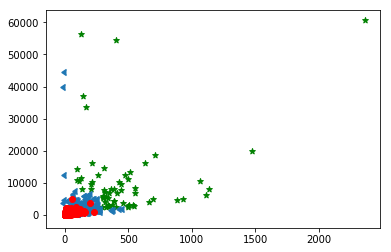

In [215]:
# 显示高、中、低价值组分布散点图（F值与M值）
plt.scatter(df_user.query("总体价值 == '高价值'")['F值'],df_user.query("总体价值 == '高价值'")['M值'],c='g', marker='*')
plt.scatter(df_user.query("总体价值 == '中价值'")['F值'],df_user.query("总体价值 == '中价值'")['M值'], marker=8)
plt.scatter(df_user.query("总体价值 == '低价值'")['F值'],df_user.query("总体价值 == '低价值'")['M值'],c='r' )


# 高价值用户覆盖在消费频率较高的区域，与F值的相关度高
# 消费金额大于 5000 元的用户中，中、高价值用户都有